# 复现报告1

# 信号策略：多项式回归

本文复现了兴业证券《基于多项式回归的股指期货日内交易策略》。本文首先验证研报所用样本区间的策略回报，所得结果与研报有较大出入。最后用较近的数据进行调参和回测，得到结果并不理想。

## 1. 信号复现

该策略基于价格对时间做多项式回归，然后求两次导数，根据导数方向预测价格走向。期货品种为沪深300股指期货，交易频率为一分钟。

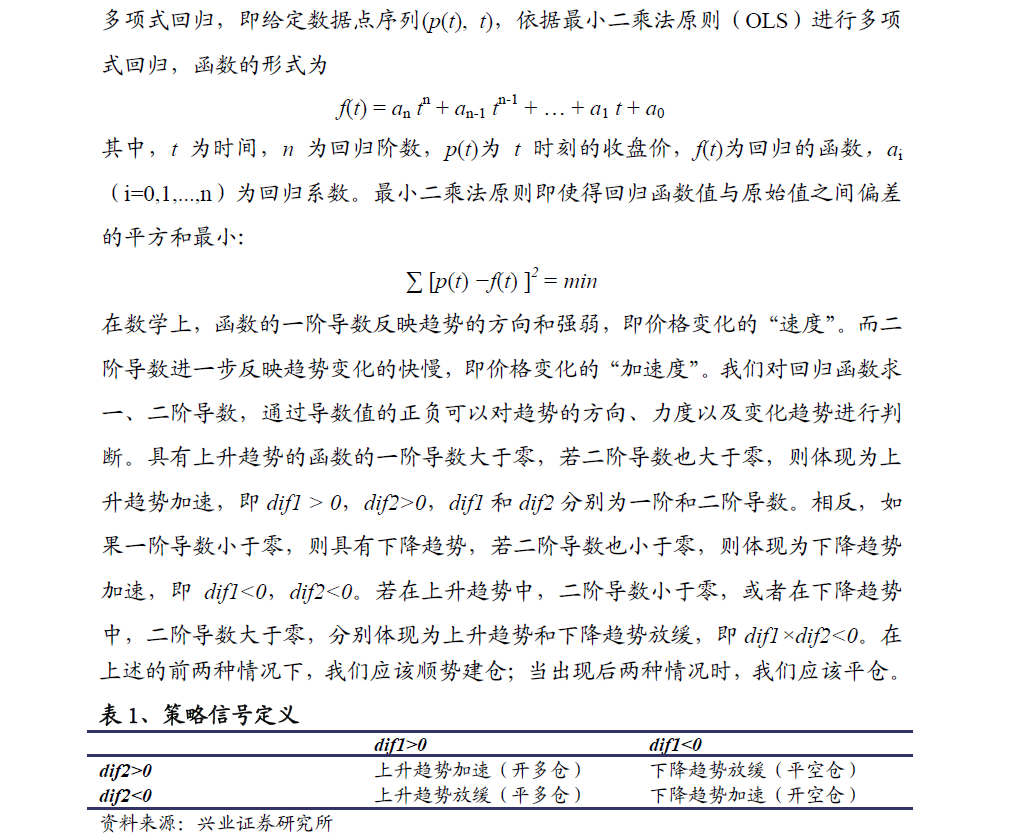

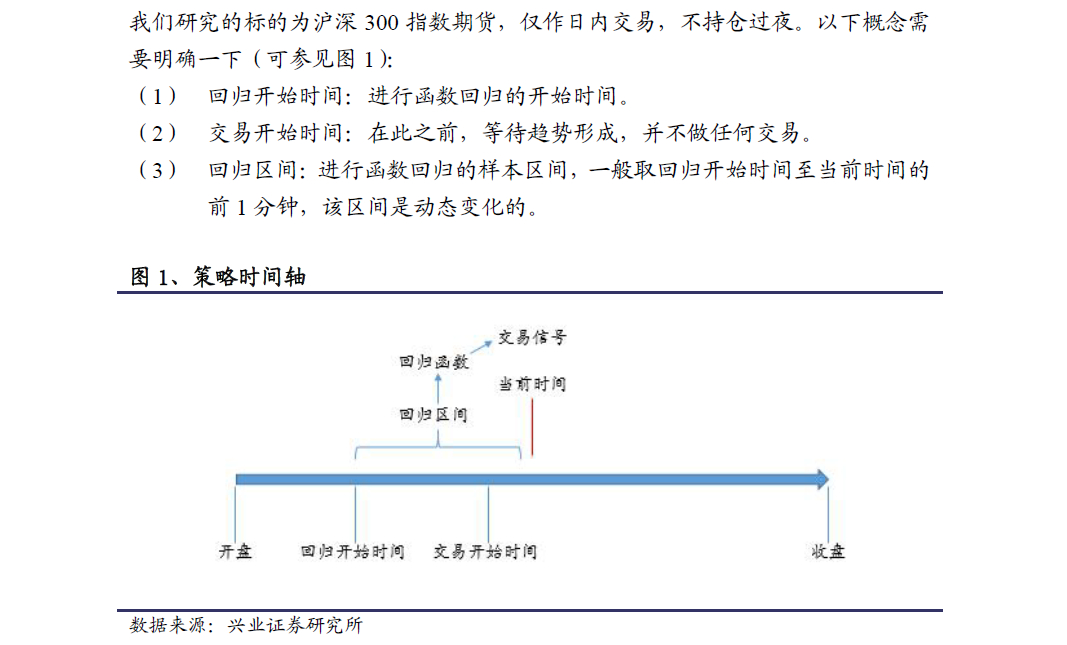

由于研报并未说明时间变量的设置和导数公式，故本文进一步明确：

1.时间变量t以回归开始时间为1，每过一分钟增加1。

2.一次导数为

$\text{dif1}(t) = \sum_{i=0}^n [i \times a_i \times t^{(i-1)}]$

二次导数为

$\text{dif2}(t) = \sum_{i=0}^n [i \times (i-1) \times a_i \times t^{(i-2)}]$

此外研报中点明了该策略有三个重要参数，分别为：回归阶数、回归开始时间和交易开始时间。本文将第三个参数改为回归开始到交易开始之前的间隔时间，单位为分钟。

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import atrader as at
import warnings
warnings.filterwarnings("ignore")

In [9]:
#粗糙的期货类
class roughFutures:
    
    def __init__(self, price, fee = 0): #price 默认用分钟级
        self.price = price
        self.fee = fee
        self.value = 1
        self.position = [0,0,0] #[仓位，开仓价格，开仓净值] 仓位：1 多头，2 空头，0 空仓
        self.record = pd.DataFrame(index = ['time','value','ifopen','ifclose'])
        self.ifopen = 0 #当前时间点是否出现开仓 0无（持有也是没有出现开仓） 1有 
        self.ifclose = 0 #当前时间点是否出现平仓 0无（持有也是没有出现平仓） 1有
        self.win_times = 0
        self.loss_times = 0
        self.win = 0
        self.loss = 0
        
    def pos_open(self, i, direction):
        if self.position[0] != direction:
            if self.position[0] == - direction:
                self.pos_close(i)
            self.position[0] = direction
            self.position[1] = self.price.loc[i,'close']
            self.value = self.value * (1 - self.fee)
            self.position[2] = self.value
            self.ifopen = direction
            
    def pos_close(self, i):
        if self.position[0] != 0:
            new_price = self.price.loc[i,'close']
            old_price = self.position[1]
            direction = self.position[0]
            old_value = self.position[2]
            ret = direction * (new_price / old_price - 1)
            if ret > 0:
                self.win_times += 1
                self.win += ret
            else:
                self.loss_times += 1
                self.loss += ret
            self.value = old_value * (1 + ret) * (1 - self.fee)
            self.position = [0,0,0]
            self.ifclose = - direction
    
    def stop_loss(self,i,stopline):
        if self.position[0] != 0:
            new_price = self.price.loc[i,'close']
            old_price = self.position[1]
            direction = self.position[0]
            ret = direction * (new_price / old_price - 1)
            if ret < - stopline:
                self.pos_close(i)
            
    def valuation(self, i):
        if self.position[0] != 0:
            new_price = self.price.loc[i,'close']
            old_price = self.position[1]
            direction = self.position[0]
            old_value = self.position[2]
            ret = direction * (new_price / old_price - 1)
            self.value = old_value * (1 + ret)
        self.record[i] = [self.price.loc[i,'time'], self.value, self.ifopen, self.ifclose]
        self.ifopen = 0
        self.ifclose = 0
        
    def show_record(self, fre = 'min'): #fre: 'min','day'
        out_min = self.record.T
        if fre == 'day':
            out_min.loc[:,'day'] = out_min['time'].apply(lambda x: str(x)[:10])
            out_day = out_min[out_min['day'] != out_min['day'].shift(-1)]
            out_min.loc[:,'ifopen'] = abs(out_min.loc[:,'ifopen']).values
            out_day.loc[:,'ifopen'] =  out_min.groupby('day')['ifopen'].sum().values
            out_min.loc[:,'ifclose'] = abs(out_min.loc[:,'ifclose']).values
            out_day.loc[:,'ifclose'] = out_min.groupby('day')['ifclose'].sum().values
            out_day.loc[:,'index'] = self.price.loc[out_day.index,'close'].values / self.price.loc[out_day.index[0],'close']
            return out_day
        else:
            out_min.loc[:,'index'] = self.price.loc[out_min.index,'close'].values
            return out_min
    
    def analysis(self, rf = 0):
        items = pd.Series(index = [])
        
        value = self.show_record('day')['value']
        ret = value.pct_change()
        n = len(value) - 1

        ann_ret = value.iloc[-1] **(252 / n) - 1
        items['Annualized return'] = ann_ret
     
        ann_std = 252**0.5 * ret.std()
        items['Annualized volatility'] = ann_std
        
        items['Sharpe ratio'] = (ann_ret - rf) / ann_std
        
        #计算最大回撤
        mdd = 0
        for i in range(n):
            new_mdd = (1 - value.iloc[i:] / value.iloc[i]).max()
            if new_mdd > mdd:
                mdd = new_mdd
        items['Max draw down'] = max(0,mdd)
        
        #计算胜率
        items['Win times'] = self.win_times
        items['Loss times'] = self.loss_times
        items['Winning rate'] = self.win_times / (self.loss_times + self.win_times)
        
        #计算盈亏比
        if self.win_times > 0:
            avg_profit = self.win / self.win_times
        else:
            avg_profit = 0
        items['Avg. profit'] =  avg_profit
        
        if self.loss_times > 0:
            avg_loss = - self.loss / self.loss_times
        else:
            avg_loss = np.nan
        items['Avg. loss'] = avg_loss
        
        items['Profit loss ratio'] = avg_profit /  avg_loss

        #平均日开仓次数
        items['Average daily open times'] = self.show_record('day')['ifopen'].mean()
        
        #与指数比较
        idx_close = self.show_record('day')['index']
        ann_idx_ret = idx_close.iloc[-1]**(252 / n) - 1
        items['Annualized return of Index'] = ann_idx_ret
            
        idx_ret = idx_close.pct_change()
        cov = pd.DataFrame([ret,idx_ret]).T.cov().iloc[0,1]
        var = idx_ret.var()
        beta = cov / var
        y_mean = ret.mean()
        x_mean = idx_ret.mean()
        alpha = y_mean - beta * x_mean
        items['Annualized Alpha'] = (alpha + 1)**252 - 1
        items['Beta'] = beta
            
        TD = ret - idx_ret
        annTE = (252**0.5*TD.std())
        items['Annualized TE'] = annTE
        items['IR'] = (ann_ret - ann_idx_ret)/ annTE

        return items        

In [10]:
#多项式回归策略
def polyReg(price, fee = 0, order = 3, regtime = '09:40', tradetime = 60): #tradetime是延迟多少分钟开始交易
    atrader = roughFutures(price, fee)
    cnt = 0
    t = []
    y = []
    reg_idx = 10000000000
    trade_idx = 10000000000
    for i in price.index:
        nowtime = str(price.loc[i,'time'])[11:16]
        if  nowtime == regtime:
            reg_idx = i
            trade_idx = i + tradetime
        elif nowtime == '15:00':
            atrader.pos_close(i)
            cnt = 0
            t = []
            y = []
            reg_idx = 10000000000
            trade_idx = 10000000000
        
        if i >= reg_idx:
            if i >= trade_idx:
                X = []
                for j in range(order+1):
                    X.append(np.array(t)**j)
                X = np.mat(X).T
                Y = np.mat([y]).T
                b = (X.T * X).I * X.T * Y
                df1 = 0
                df2 = 0
                for j in range(order+1):
                    df1 += j * b[j,0] * cnt**(j-1)
                    df2 += (j-1) * j * b[j,0] * cnt**(j-2)
                if df1 > 0 and df2 > 0:
                    atrader.pos_open(i, 1)
                elif df1 < 0 and df2 < 0:
                    atrader.pos_open(i, -1)
                else:
                    atrader.pos_close(i)
            #交易当时不用当时的收盘价
            cnt += 1
            t.append(cnt)
            y.append(price.loc[i,'close'])
        atrader.valuation(i)
    
    return atrader.show_record(), atrader.show_record('day'), atrader.analysis()

下面验证研报中的样本外回报，除了买卖价格本文使用收盘价以外，其他都与研报相同，即回测区间为2013-06-01至2014-05-30，手续费为万分之0.4，回归阶数为3，回归开始时间为09:45，间隔时间为85分钟。

In [11]:
#获取研报样本外区间内的数据
repdata = at.get_kdata(target_list = ['cffex.if0000'], 
                      frequency = 'min', 
                      fre_num = 1, 
                      begin_date = '2013-05-31', 
                      end_date = '2014-05-30',
                      fq = 1,
                      fill_up = False, 
                      df = True,
                      sort_by_date = False)

In [12]:
repprice = repdata.loc[253:,['time','close']]

In [13]:
min_rep,day_rep, res_rep = polyReg(repprice, 0.4/10000, 3, '09:45',85)

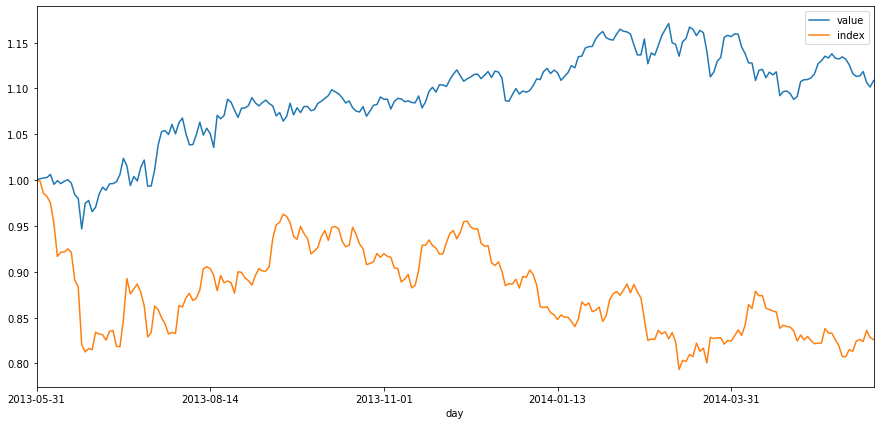

In [14]:
day_rep.loc[:,['day','value','index']].set_index('day').plot(figsize = (15,7))
plt.show()

In [15]:
res_rep

Annualized return               0.11385
Annualized volatility           0.13928
Sharpe ratio                    0.81744
Max draw down                   0.07073
Win times                     322.00000
Loss times                    236.00000
Winning rate                    0.57706
Avg. profit                     0.00344
Avg. loss                       0.00403
Profit loss ratio               0.85410
Average daily open times        2.30579
Annualized return of Index     -0.18110
Annualized Alpha                0.14328
Beta                            0.09294
Annualized TE                   0.23876
IR                              1.23536
dtype: float64

回测所得结果与研报相比较差距较大，并没有达到37.33%的年化收益率和2.34的夏普比率，胜率和盈亏比的关系也相反。由于研报对策略细节描述不详，而本文亦未检查出代码和设计错误，因此不知道如何调整才能达到研报的效果。

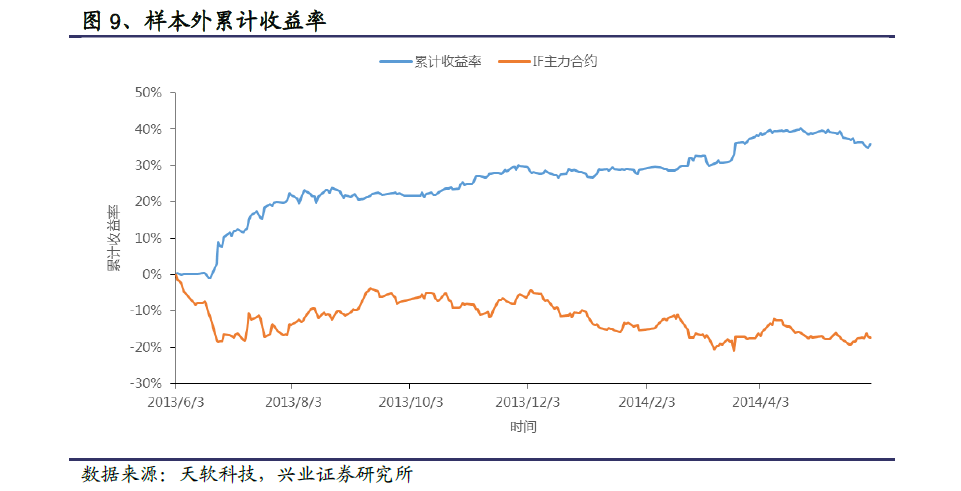

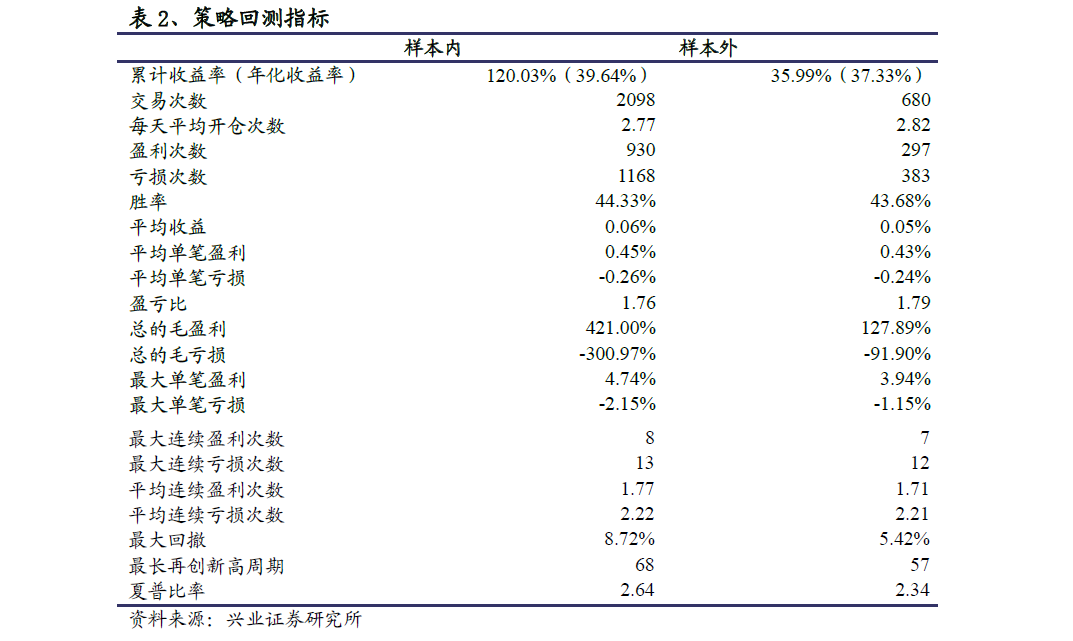

## 2. 参数优化

研报展示了每个参数不同取值下的累积收益率，但是并未说明某参数变动时其他参数的取值情况，因此无法复原研报所用的参数优化方法。

本文采取简单的全局优化，三个参数各取若干值，依次做样本内回测，取夏普比率最高的一组参数。样本内区间为2018-07-02至2019-06-28共一年时间，样本外区间为2019-07-01至2019-12-31共半年时间。

In [375]:
#参数优化
def optimal(in_IF,fee = 0.4/10000):
    order_list = [2,3,4,5,6]
    regtime_list = ['09:31','09:40','09:50','10:00','10:10','10:20','10:30']
    tradetime_list = [20,40,60,80,100,120]
    opt_df = pd.DataFrame(index = ['order','regtime','tradetime',
                                   'Annualized return',
                                   'Sharpe ratio',
                                   'Annualized Alpha',
                                   'IR',
                                   'Average daily open times'])
    cnt = 0
    for i in order_list:
        for j in regtime_list:
            for k in tradetime_list:
                cnt += 1
                minr,dayr,res = polyReg(in_IF, fee, i, j, k)
                opt_df[cnt] = [i,j,k,
                               res['Annualized return'],
                               res['Sharpe ratio'],
                               res['Annualized Alpha'],
                               res['IR'],
                               res['Average daily open times']] 
    return opt_df.T

In [16]:
#获取数据
IFdata = at.get_kdata(target_list = ['cffex.if0000'], 
                      frequency = 'min', 
                      fre_num = 1, 
                      begin_date = '2018-06-29', 
                      end_date = '2019-12-31',
                      fq = 1,
                      fill_up = False, 
                      df = True,
                      sort_by_date = False)
IFdata.to_csv('data/IFdata.csv')

In [17]:
IFprice = IFdata.loc[:,['time','close']]

In [18]:
timelist = list(IFprice['time'].apply(lambda x: str(x)[:16]))

In [19]:
in_start = timelist.index('2018-06-29 14:59')
in_end = timelist.index('2019-06-28 15:00')
in_IF = IFprice.iloc[in_start:(in_end + 1),:]
out_IF = IFprice.iloc[in_end:,:]

下面用样本内数据进行参数优化。

In [382]:
opt_df = optimal(in_IF).sort_values('Sharpe ratio',ascending = False)
opt_df.to_csv('data/opt_df.csv')

In [383]:
opt_df

,order,regtime,tradetime,Annualized return,Sharpe ratio,Annualized Alpha,IR,Average daily open times
57,3,09:50,60,0.21836,1.227,0.2596,0.33001,2.5546
61,3,10:00,20,0.1672,0.88524,0.20964,0.17854,5.0966
58,3,09:50,80,0.14518,0.8415,0.18193,0.11943,2.3319
56,3,09:50,40,0.14462,0.79444,0.18351,0.11604,3.7353
62,3,10:00,40,0.13911,0.77159,0.17962,0.099617,3.7143
63,3,10:00,60,0.10338,0.59746,0.14196,-0.0029505,2.6345
59,3,09:50,100,0.087049,0.4972,0.12489,-0.050158,2.0882
55,3,09:50,20,0.077282,0.40994,0.11233,-0.07836,5.1429
51,3,09:40,60,0.074608,0.39182,0.11489,-0.084253,2.5504
50,3,09:40,40,0.060289,0.3027,0.10279,-0.12269,3.6807


最优参数为：回归阶数3，回归开始时间09:50，间隔时间60分钟。

下面代入最优参数，用样本外数据进行回测。

In [24]:
min_out,day_out,res_out = polyReg(out_IF, 0.4/10000, opt_df.iloc[0,0], opt_df.iloc[0,1],opt_df.iloc[0,2])

In [25]:
res_out

Annualized return              -0.08212
Annualized volatility           0.07672
Sharpe ratio                   -1.07037
Max draw down                   0.09608
Win times                     164.00000
Loss times                    156.00000
Winning rate                    0.51250
Avg. profit                     0.00215
Avg. loss                       0.00236
Profit loss ratio               0.91076
Average daily open times        2.51969
Annualized return of Index      0.15871
Annualized Alpha               -0.08718
Beta                            0.05389
Annualized TE                   0.15152
IR                             -1.58943
dtype: float64

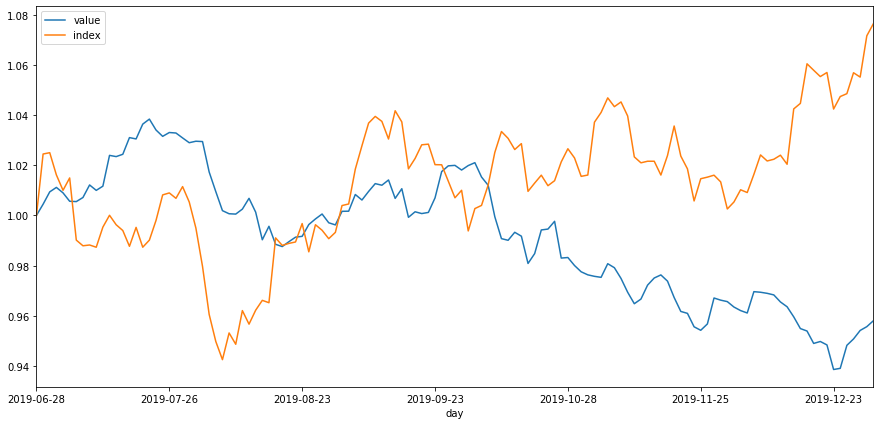

In [26]:
day_out.loc[:,['day','value','index']].set_index('day').plot(figsize = (15,7))
plt.show()

回测结果不忍直视，并没有继续样本内取得的高收益，最终累积收益为负，大大低于股指期货本身。其中可以明显看到在7月和9月该策略还能取得较好的收益，随后就一路震荡下跌。

后续还尝试了动态调参的方法，如每周先根据前一个月的数据进行参数优化后再入场，但是结果仍旧不理想，故文本没有展示。

复现中未能达到研报所述的高收益，实属遗憾。